# DMS simple neural network

I use DMS experiments as a training set and try to predict the effect of mutations in a LOPO fashion.

## Load the training data

I use the save csv data from `dms_dataset_creation`.

In [3]:
import pandas as pd

df = pd.read_csv("/home/saul/master_thesis_work/dataset/dms/dms_training.csv")
df

/home/saul/tf2.4/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,protein,dms_id,uniprot_id,position,aa1,aa2,reported_fitness,pdb_id,pdb_chain,author_year,...,hmm_pssm_aa1_likelyhood,hmm_pssm_aa2_likelyhood,hmm_pssm_delta_likelyhood,tr_rosetta_feature_index,tr_rosetta_graph_closeness_centrality,tr_rosetta_graph_betweenness_centrality,tr_rosetta_graph_degree_centrality,tr_rosetta_graph_load_centrality,tr_rosetta_graph_harmonic_centrality,tr_rosetta_graph_clustering
0,TEM-1,beta-lactamase,P62593,20,P,P,0.581033,1btl,A,Firnberg2014,...,2.81126,2.81126,0.00000,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
1,TEM-1,beta-lactamase,P62593,20,P,Q,0.441480,1btl,A,Firnberg2014,...,2.81126,3.27353,0.46227,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
2,TEM-1,beta-lactamase,P62593,20,P,D,0.289750,1btl,A,Firnberg2014,...,2.81126,2.92236,0.11110,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
3,TEM-1,beta-lactamase,P62593,20,P,K,0.196582,1btl,A,Firnberg2014,...,2.81126,2.72602,-0.08524,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
4,TEM-1,beta-lactamase,P62593,20,P,N,0.053725,1btl,A,Firnberg2014,...,2.81126,3.00679,0.19553,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21837,Yap65,WW_domain,P46937,203,R,C,-2.667780,4rex,A,Fowler2010,...,0.59945,5.62776,5.02831,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000
21838,Yap65,WW_domain,P46937,203,R,G,-2.731940,4rex,A,Fowler2010,...,0.59945,3.26877,2.66932,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000
21839,Yap65,WW_domain,P46937,203,R,D,-2.850370,4rex,A,Fowler2010,...,0.59945,3.95240,3.35295,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000
21840,Yap65,WW_domain,P46937,203,R,H,-3.011270,4rex,A,Fowler2010,...,0.59945,4.16162,3.56217,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000


## Selecting the features to use

In [4]:
features = [
    "aa1",
    "aa2",
    #'ev_frequency',
    #'ev_conservation',
    #'ev_independent',
    #'ev_epistatic',
    "netsurf_rsa",
    #'netsurf_asa',
    #'netsurf_p_q3_H','netsurf_p_q3_E','netsurf_p_q3_C',
    #'netsurf_p_q8_G','netsurf_p_q8_H','netsurf_p_q8_I','netsurf_p_q8_B',
    #'netsurf_p_q8_E','netsurf_p_q8_S','netsurf_p_q8_T','netsurf_p_q8_C',
    #'netsurf_phi',
    #'netsurf_psi',
    "netsurf_disorder",
    "hmm_pssm_A",
    "hmm_pssm_C",
    "hmm_pssm_D",
    "hmm_pssm_E",
    "hmm_pssm_F",
    "hmm_pssm_G",
    "hmm_pssm_H",
    "hmm_pssm_I",
    "hmm_pssm_K",
    "hmm_pssm_L",
    "hmm_pssm_M",
    "hmm_pssm_N",
    "hmm_pssm_P",
    "hmm_pssm_Q",
    "hmm_pssm_R",
    "hmm_pssm_S",
    "hmm_pssm_T",
    "hmm_pssm_V",
    "hmm_pssm_W",
    "hmm_pssm_Y",
    #'hmm_pssm_aa1_likelyhood',
    #'hmm_pssm_aa2_likelyhood',
    #'hmm_pssm_delta_likelyhood'
]

is_categorical = [
    "aa1",
    "aa2",
]

is_aa = ["aa1", "aa2"]

x = pd.DataFrame()

# convert categorical features in integers for the embedding
for feature in features:
    if feature in is_categorical:
        x[feature] = df[feature].factorize(sort=True)[0]
    else:
        x[feature] = df[feature]

x_aa = x[is_aa].to_numpy(dtype=int)
x_n = x.drop(is_categorical, axis=1).to_numpy(dtype=float)

## Create model

I declare some functions that define the model and the plotting routines for the results and for feature importance

In [7]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import (
    MinMaxScaler,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)

import seaborn as sns

sns.set()


def get_model():
    # residue embedding branch
    inputs_aa = tf.keras.Input(shape=2)
    x_aa = tf.keras.layers.Embedding(input_dim=20, output_dim=10, mask_zero=False)(
        inputs_aa
    )
    x_aa = tf.keras.layers.Flatten()(x_aa)
    # common branch
    inputs_n = tf.keras.Input(shape=22)
    x = tf.keras.layers.Concatenate()([x_aa, inputs_n])
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(
        inputs=(inputs_aa, inputs_n), outputs=outputs, name="dms_simple_nn"
    )
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.mean_squared_error
    model.compile(optimizer=optimizer, loss=loss)
    return model


def preprocess_features(x, train_bool):
    imp = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    imp.fit(x[train_bool])
    x_imp = imp.transform(x)
    scaler.fit(x_imp[train_bool])
    x_imp_scaled = scaler.transform(x_imp)
    return x_imp_scaled


def lopo_plots_and_correlation(x_aa, x_n, df, target, nn_params):
    lopo = LeaveOneGroupOut()
    y = np.array(df[target])
    is_wt = np.array(df.aa1 == df.aa2)
    for train, val in lopo.split(x, groups=df.protein):
        curr_protein_tested = set(df.protein.iloc[val])
        model = get_model()
        x_curr_n = preprocess_features(x_n, train)
        model.fit(
            (x_aa[train], x_curr_n[train]),
            y[train],
            epochs=nn_params["epochs"],
            validation_data=((x_aa[val], x_curr_n[val]), y[val]),
        )
        y_pred = model.predict((x_aa, x_curr_n)).flatten()
        train_spearman_list = []
        for dataset in list(set(df.dms_id.iloc[train])):
            bool_to_consider = np.array(df.dms_id == dataset)
            train_spearman_list.append(
                stats.spearmanr(y_pred[bool_to_consider], y[bool_to_consider])[0]
            )
        train_spearman = np.average(train_spearman_list)
        for dataset in list(set(df.dms_id.iloc[val])):
            bool_to_consider = np.array(df.dms_id == dataset)
            print("Dataset:", dataset)
            print("Protein:", curr_protein_tested)
            print("Uniprot ID:", set(df.uniprot_id.iloc[bool_to_consider]))
            print("Basename:", set(df.feature_basename.iloc[bool_to_consider]))
            val_spearman = stats.spearmanr(
                y_pred[bool_to_consider], y[bool_to_consider]
            )[0]
            print("val spearman:", val_spearman, "train spearman:", train_spearman)
            plt.close()
            sns.scatterplot(
                x=y[bool_to_consider & ~is_wt],
                y=y_pred[bool_to_consider & ~is_wt],
                marker="x",
            )
            sns.scatterplot(
                x=y[bool_to_consider & is_wt],
                y=y_pred[bool_to_consider & is_wt],
                s=100,
                alpha=0.5,
            )
            plt.show()

Epoch 1/2
508/508 [==============================] - 1s 1ms/step - loss: 0.1555 - val_loss: 0.0814
Epoch 2/2
508/508 [==============================] - 0s 940us/step - loss: 0.0732 - val_loss: 0.0738
Dataset: kka2_1:2
Protein: {'Kka2'}
Uniprot ID: {'P00552'}
Basename: {'P00552'}
val spearman: 0.4624544607381064 train spearman: 0.5784064967658579


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


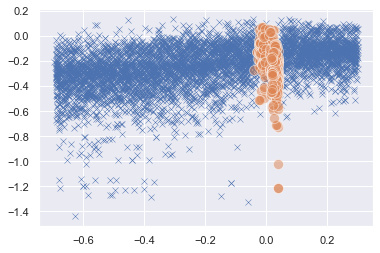

Epoch 1/2
634/634 [==============================] - 1s 875us/step - loss: 0.1463 - val_loss: 0.1237
Epoch 2/2
634/634 [==============================] - 1s 846us/step - loss: 0.0678 - val_loss: 0.1386
Dataset: PSD95pdz3
Protein: {'PSD95pdz3'}
Uniprot ID: {'P31016'}
Basename: {'P31016'}
val spearman: 0.44522033289243274 train spearman: 0.5814169396374722


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


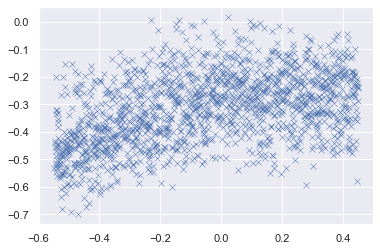

Epoch 1/2
645/645 [==============================] - 1s 898us/step - loss: 0.1237 - val_loss: 0.0775
Epoch 2/2
645/645 [==============================] - 0s 774us/step - loss: 0.0662 - val_loss: 0.0754
Dataset: Pab1
Protein: {'Pab1'}
Uniprot ID: {'P04147'}
Basename: {'P04147'}
val spearman: 0.5772961194933747 train spearman: 0.5752570938710078


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


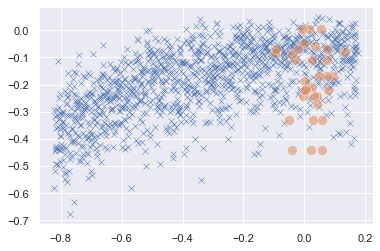

Epoch 1/2
514/514 [==============================] - 1s 1ms/step - loss: 0.1684 - val_loss: 0.0840
Epoch 2/2
514/514 [==============================] - 0s 882us/step - loss: 0.0772 - val_loss: 0.0676
Dataset: beta-lactamase
Protein: {'TEM-1'}
Uniprot ID: {'P62593'}
Basename: {'P62593'}
val spearman: 0.5211533263418184 train spearman: 0.5696060283400908


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


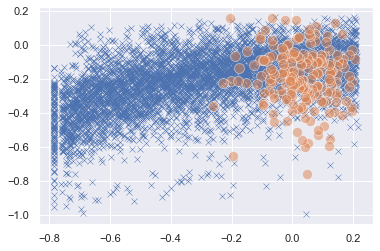

Epoch 1/2
608/608 [==============================] - 1s 952us/step - loss: 0.1584 - val_loss: 0.0960
Epoch 2/2
608/608 [==============================] - 0s 760us/step - loss: 0.0716 - val_loss: 0.0842
Dataset: E1_Ubiquitin
Protein: {'UBI4'}
Uniprot ID: {'P0CG63'}
Basename: {'P0CG63_1-76'}
val spearman: 0.43803796682753515 train spearman: 0.5806396737862531


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


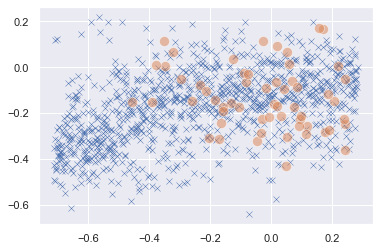

Dataset: Ubiquitin
Protein: {'UBI4'}
Uniprot ID: {'P0CG63'}
Basename: {'P0CG63_1-76'}
val spearman: 0.2560632227525365 train spearman: 0.5806396737862531


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


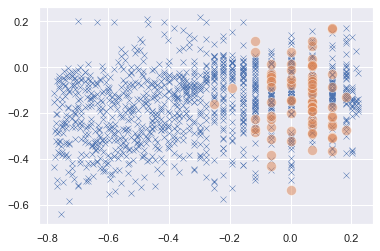

Epoch 1/2
671/671 [==============================] - 1s 861us/step - loss: 0.1549 - val_loss: 0.0693
Epoch 2/2
671/671 [==============================] - 0s 711us/step - loss: 0.0673 - val_loss: 0.0699
Dataset: WW_domain
Protein: {'Yap65'}
Uniprot ID: {'P46937'}
Basename: {'P46937'}
val spearman: 0.4189235811626703 train spearman: 0.587730175738551


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


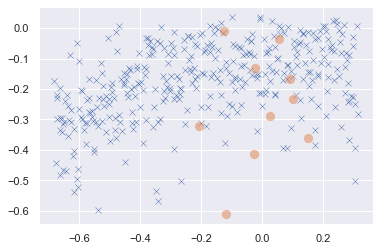

Epoch 1/2
651/651 [==============================] - 1s 1ms/step - loss: 0.1439 - val_loss: 0.0706
Epoch 2/2
651/651 [==============================] - 0s 767us/step - loss: 0.0686 - val_loss: 0.0684
Dataset: gb1
Protein: {'gb1'}
Uniprot ID: {'P06654'}
Basename: {'P06654'}
val spearman: 0.4750705346724575 train spearman: 0.5716141973682245


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


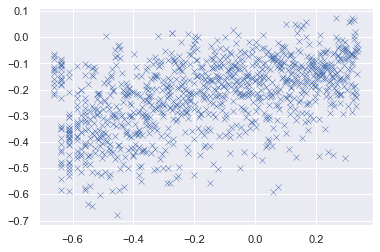

Epoch 1/2
551/551 [==============================] - 1s 1ms/step - loss: 0.1360 - val_loss: 0.0774
Epoch 2/2
551/551 [==============================] - 0s 901us/step - loss: 0.0674 - val_loss: 0.0786
Dataset: hsp90
Protein: {'hsp90'}
Uniprot ID: {'P02829'}
Basename: {'P02829_2-231'}
val spearman: 0.3211216903970344 train spearman: 0.5939800142244854


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


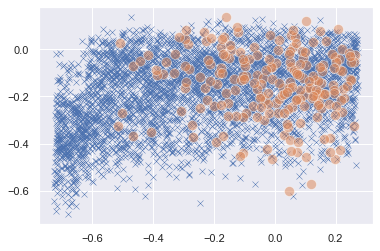

In [8]:
nn_params = {
    "epochs": 2,
}
lopo_plots_and_correlation(x_aa, x_n, df, "reported_fitness_quantile", nn_params)